라이브러리 임포트



In [ ]:
from typing import Annotated, Optional, Literal, List, Dict, Any
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
import enum
import os
from dotenv import load_dotenv
import uuid

# LangChain 및 기타 필요한 라이브러리 임포트
from langchain_anthropic import ChatAnthropic
from langchain.prompts import ChatPromptTemplate
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.messages.base import BaseMessage

# LangGraph 관련 임포트
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# 기존 RAG 코드에서 가져온 컴포넌트
from langchain_upstage import UpstageDocumentParseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from sentence_transformers import SentenceTransformer

# 랭퓨즈
from langfuse import Langfuse, get_client
from langfuse.langchain import CallbackHandler

# 스트리밍
import asyncio
from langchain_core.output_parsers import StrOutputParser

# 서치 툴 travily
import getpass
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
import json
from langgraph.prebuilt import tools_condition

/Users/baegjonghun/.pyenv/versions/3.11.10/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


설정 및 초기화

In [ ]:
# .env 파일 로드 (필요한 경우)
load_dotenv()



유틸리티 함수

In [ ]:
# Format documents function
def format_docs(docs):
    """Format documents into a single string"""
    return "\n\n".join(doc.page_content for doc in docs)


# 1. initialize_rag_components 
def initialize_rag_components(file_path: str = "./test_modified.pdf"):
    """Initialize all components for RAG"""
    print("문서 로딩 중...")

    # Document loading
    loader = UpstageDocumentParseLoader(
        file_path,
        split="page",
        output_format="markdown",
        ocr="auto",
        coordinates=True,
    )
    docs = loader.load()
    print(f"문서 로딩 완료: {len(docs)} 페이지")

    # Document chunking
    print("문서 청킹 중...")
    splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=300)
    docs_splitter = splitter.split_documents(docs)
    print(f"청킹 완료: {len(docs_splitter)} 청크")

    # Embedding model
    print("임베딩 모델 로딩 중...")
    device = "cpu"  # 기본값으로 CPU 사용
    try:
        import torch

        if torch.cuda.is_available():
            device = "cuda"
        elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
            device = "mps"
    except ImportError:
        pass

    print(f"사용 중인 디바이스: {device}")

    hf_embeddings = HuggingFaceEmbeddings(
        model_name="intfloat/multilingual-e5-large-instruct",
        model_kwargs={"device": device},
        encode_kwargs={"normalize_embeddings": True},
    )

    # Vector store
    print("벡터 스토어 생성 중...")
    vectorstore = FAISS.from_documents(
        documents=docs_splitter,
        embedding=hf_embeddings,
    )
    print("벡터 스토어 생성 완료")

    # Retriever
    retriever = vectorstore.as_retriever(
        search_type="similarity",
        search_kwargs={"k": 5},
    )

    # Sonnet 4 LLM - 모든 작업용
    print("🚀 Sonnet 4 LLM 초기화 중...")
    sonnet_llm = ChatAnthropic(
        model="claude-sonnet-4-20250514",
        temperature=0,
        streaming=True,
    )

    # 웹 검색 툴과 바인딩
    tools = [tavily_web_search]
    sonnet_llm_with_tools = sonnet_llm.bind_tools(tools)

    print("✅ Sonnet 4 LLM 초기화 완료!")

    return {
        "retriever": retriever,
        "llm": sonnet_llm,  # 모든 작업용 Sonnet 4
        "llm_with_tools": sonnet_llm_with_tools,  # 웹 검색용 Sonnet 4
        "tools": tools,
    }

모델 클래스

In [ ]:
# Define categories for query classification
class Category(enum.Enum):
    DOCUMENT = "document"  # 문서 관련 질문
    GENERAL = "general"  # 일반적인 질문


# Pydantic model for structured output
class QueryClassification(BaseModel):
    """사용자 쿼리 분류 모델"""

    category: Category = Field(
        description="쿼리를 카테고리화 하세요. DOCUMENT(문서 관련 질문) / GENERAL(일반적인 질문) 중에 하나로 구분하세요."
    )
    reasoning: str = Field(description="왜 이 카테고리를 선택했는지 설명하세요.")


# Define the state structure
class State(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    context: List[str]
    category: Optional[str]
    transformed_query: Optional[str]  # 🆕 변환된 쿼리 저장


# 2. setup_tool 함수 단순화
def setup_tool():
    """웹 검색 툴 노드 생성"""
    global rag_components

    # ToolNode 생성 (이미 rag_components에 tools가 있음)
    tool_node = ToolNode(rag_components["tools"])

    print("✅ 웹 검색 툴 설정 완료!")
    return tool_node


# 3. router 함수 수정 - Sonnet 4 사용
def router(state: State) -> Dict[str, Any]:
    """사용자 쿼리를 카테고리로 분류하는 라우터 - Sonnet 4 사용"""
    print("🚀 쿼리 분류 중 (Sonnet 4)...")

    # Get the most recent user message
    user_message = state["messages"][-1].content

    # Create the router input
    router_input = f"""
    다음 사용자 쿼리를 분석하고 카테고리를 결정하세요.
    카테고리:
    - document: 문서 내용에 관한 질문 (예: "아주대학교에 대해 알려줘", "이 문서에서 중요한 내용은?")
    - general: 일반적인 질문으로, 문서와 관련이 없음 (예: "오늘 날씨 어때?", "파이썬이란?")
    
    쿼리: {user_message}
    """

    # Sonnet 4 LLM 사용
    llm = rag_components["llm"]

    # Structured output with the classification model
    structured_llm = llm.with_structured_output(QueryClassification)

    # Get classification
    classification = structured_llm.invoke(router_input)

    category = classification.category.value
    print(f"분류 결과: {category} (이유: {classification.reasoning}) - Sonnet 4")

    return {"category": category}


# Conditional routing function
def route_by_category(state: State) -> Literal["document_qa", "general_qa"]:
    """카테고리에 기반하여 다음 노드를 결정"""
    category = state.get("category", "").lower()

    if category == "document":
        return "document_qa"
    elif category == "general":
        return "general_qa"
    else:
        # 기본값은 일반 질의응답
        return "general_qa"


def query_transform(state: State) -> Dict[str, Any]:
    """사용자 쿼리를 문서 검색에 최적화된 형태로 변환"""
    print("🔄 쿼리 변환 중 (Sonnet 4)...")

    # 사용자 메시지 추출
    user_message = None
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            user_message = msg.content
            break

    if not user_message:
        return {"transformed_query": ""}

    # 이전 대화 히스토리 구성
    history_messages = state["messages"][:-1]
    formatted_history = ""
    for msg in history_messages:
        role = "사용자" if isinstance(msg, HumanMessage) else "AI"
        formatted_history += f"{role}: {msg.content}\n"

    # Query Transform 프롬프트
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """너는 문서 검색 쿼리 최적화 전문가야.
        사용자의 질문을 분석해서 문서에서 관련 정보를 더 잘 찾을 수 있도록 쿼리를 변환해.
        
        ## 쿼리 변환 규칙:
        1. **핵심 키워드 추출**: 불필요한 단어 제거하고 핵심 단어만 남기기
        2. **동의어 확장**: 관련 용어들 추가 (예: "대학교" → "대학교, 대학, 학교")
        3. **검색 최적화**: 문서에서 찾기 쉬운 형태로 변환
        4. **컨텍스트 반영**: 이전 대화 맥락을 고려한 쿼리 확장
        5. **구체화**: 모호한 표현을 구체적으로 변환
        
        ## 변환 예시:
        - "아주대에 대해 알려줘" → "아주대학교 대학 정보 개요 소개"
        - "입학 조건이 뭐야?" → "입학 조건 지원 자격 요건 모집"
        - "학과는 어떤게 있어?" → "학과 전공 단과대학 계열 전공분야"
        
        ## 응답 형식:
        쿼리가 어떻게 변경되었는지 알려줘
        
        이전 대화:
        {chat_history}
        """,
            ),
            ("user", "원본 쿼리: {original_query}"),
        ]
    )

    # Sonnet 4 사용
    llm = rag_components["llm"]

    formatted_message = prompt.format_messages(
        chat_history=formatted_history, original_query=user_message
    )

    ai_response = llm.invoke(formatted_message)
    transformed_query = ai_response.content.strip()

    print(f"✅ 쿼리 변환 완료: '{user_message}' → '{transformed_query}'")

    return {"transformed_query": transformed_query}


# Define LangGraph nodes
def retrieve_documents(state: State) -> Dict[str, Any]:
    """문서에서 관련 내용 검색"""
    print("문서 검색 중...")

    # Get the most recent user message
    user_message = state["messages"][-1]

    # Retrieve documents
    retriever = rag_components["retriever"]
    docs = retriever.invoke(user_message.content)

    # Format documents
    formatted_docs = format_docs(docs)
    print(f"검색 완료: {len(docs)} 문서 찾음")

    # Return updated state
    return {"context": [formatted_docs]}


# 1. TavilySearch 인스턴스를 올바르게 생성
tavily_search_tool = TavilySearch(max_results=3, topic="general")


@tool
def tavily_web_search(query: str) -> str:
    """웹에서 최신 정보를 검색합니다. 뉴스, 날씨, 실시간 데이터 등에 사용하세요."""
    print(f"🌐 Tavily 웹 검색 중: {query}")

    try:
        # 이제 tavily_search_tool이 올바른 TavilySearch 인스턴스임
        search_results = tavily_search_tool.invoke({"query": query})
        print(f"✅ 검색 결과 받음: {type(search_results)}")

        # 결과 포맷팅
        if isinstance(search_results, list):
            if len(search_results) == 0:
                return "검색 결과가 없습니다."

            formatted_results = []
            for i, result in enumerate(search_results[:3]):  # 상위 3개만
                title = result.get("title", "N/A")
                content = result.get("content", "N/A")
                url = result.get("url", "N/A")

                formatted_results.append(
                    f"""
검색 결과 {i+1}:
제목: {title}
내용: {content[:300] if content != 'N/A' else 'N/A'}...
출처: {url}
"""
                )
            return "\n".join(formatted_results)
        else:
            return f"검색 결과: {str(search_results)[:500]}"

    except Exception as e:
        error_msg = f"웹 검색 중 오류 발생: {str(e)}"
        print(f"❌ {error_msg}")
        return error_msg


print("✅ 웹 검색 툴 함수 업데이트 완료!")


# 웹 검색 툴을 기존 LLM에 바인딩
def bind_web_search_to_llm():
    """기존 LLM에 웹 검색 툴을 바인딩합니다."""
    global rag_components

    # 웹 검색 툴 리스트
    tool = [tavily_web_search]

    # 기존 LLM에 툴 바인딩
    llm = rag_components["llm"]
    llm_with_tools = llm.bind_tools(tool)

    # rag_components 업데이트
    rag_components["llm_with_tools"] = llm_with_tools
    rag_components["tool"] = tool

    print("✅ 기존 LLM에 웹 검색 툴 바인딩 완료!")
    return llm_with_tools



# 4. document_qa 함수 수정 - Sonnet 4 사용
def document_qa(state: State) -> Dict[str, Any]:
    """문서 기반 질의응답 - Sonnet 4 사용"""
    print("🚀 문서 기반 응답 생성 중 (Sonnet 4)...")
    context = state["context"][0] if state["context"] else "문서 정보 없음"

    # Get user message
    user_message = state["messages"][-1].content

    # 이전 대화들은 별도로 히스토리 구성
    history_messages = state["messages"][:-1]
    formatted_history = ""
    for msg in history_messages:
        role = "사용자" if isinstance(msg, HumanMessage) else "AI"
        formatted_history += f"{role}: {msg.content}\\n"

    # Create prompt
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """너는 친절한 한국어 AI 비서야. 
        제공된 문서 내용(context)과 이전 대화 내용을 참고해서 질문에 답해.
        반드시 한국어로만 대답하고, 문서에 없는 내용은 대답하지 말고 모른다고 해.
        
        참고 문서:
        {context}
        
        이전 대화:
        {chat_history}
        """,
            ),
            ("user", "{user_input}"),
        ]
    )

    # Sonnet 4 LLM 사용
    llm = rag_components["llm"]

    # Create formatted message for LLM
    formatted_message = prompt.format_messages(
        context=context,
        chat_history=formatted_history,
        user_input=user_message,
    )

    # Get response from LLM
    ai_response = llm.invoke(formatted_message)
    response_content = ai_response.content
    print("✅ 문서 기반 응답 생성 완료 (Sonnet 4)")

    # Return the assistant message
    return {"messages": [AIMessage(content=response_content)]}


# 5. general_qa 함수 수정 - Sonnet 4 with Tools 사용
def general_qa(state: State) -> Dict[str, Any]:
    """일반 질의응답 - Sonnet 4 with Tools 사용"""
    print("🚀 일반 응답 생성 중 (Sonnet 4 + 웹 툴)...")

    user_message = state["messages"][-1].content

    # 이전 대화 히스토리 구성
    history_messages = state["messages"][:-1]
    formatted_history = ""
    for msg in history_messages:
        role = "사용자" if isinstance(msg, HumanMessage) else "AI"
        formatted_history += f"{role}: {msg.content}\\n"

    # Sonnet 4 + 툴 사용
    llm_with_tools = rag_components["llm_with_tools"]

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """너는 친절한 한국어 AI 비서야. 
        사용자의 일반적인 질문에 답변해. 
        만약 최신 정보나 실시간 데이터가 필요하다면 (날씨, 뉴스, 주식 등), tavily_web_search 툴을 사용해서 웹에서 정보를 찾아줘. 
## ReAct 단계별 처리 방식:

**1단계 - 사고 (Thought):** 사용자의 질문을 분석하고 어떤 정보가 필요한지 생각해
- 이 질문에 답하기 위해 무엇이 필요한가?
- 내가 이미 알고 있는 정보인가, 아니면 최신 정보가 필요한가?
- 웹 검색이 필요한가?

**2단계 - 행동 (Action):** 필요하다면 적절한 도구를 사용해
- 최신 정보나 실시간 데이터가 필요하면: tavily_web_search 툴 사용
- 일반 상식으로 답변 가능하면: 바로 답변

**3단계 - 관찰 (Observation):** 도구 사용 결과를 분석해
- 검색 결과가 질문에 적합한가?
- 추가 정보가 필요한가?

**4단계 - 답변 (Answer):** 최종 답변을 제공해

## 답변 형식:
**사고:** [질문 분석 및 필요한 정보 판단]
**행동:** [취할 행동 - 웹 검색 또는 직접 답변]
**답변:** [사용자에게 제공할 최종 답변]

## 웹 검색이 필요한 경우:
- 날씨, 뉴스, 주식 가격
- 현재 날짜, 시간
- 최신 사건, 트렌드
- 실시간 데이터

## 직접 답변 가능한 경우:
- 일반 상식, 역사적 사실
- 수학 계산, 언어 번역
- 개념 설명, 정의
- 기본적인 인사말
         

## 일반적인 상식으로 답변 가능한 질문은 바로 답변해.
        
        이전 대화:
        {chat_history}
        """,
            ),
            ("user", "{user_input}"),
        ]
    )

    formatted_message = prompt.format_messages(
        chat_history=formatted_history,
        user_input=user_message,
    )

    ai_response = llm_with_tools.invoke(formatted_message)
    print("✅ 일반 응답 생성 완료 (Sonnet 4)")

    return {"messages": [ai_response]}

✅ 웹 검색 툴 함수 업데이트 완료!


그래프 노드 함수 및 그래프 빌드 및 실행

In [ ]:
# 1. 먼저 필요한 변수들 정의
conversation_history = []  # 전체 대화 히스토리 저장



# 5. Interactive chat 함수
def interactive_chat():
    global conversation_history
    """Interactive chat interface for the RAG system"""
    print("=" * 60)
    print("🤖 LangGraph 라우팅 RAG 챗봇 시작 (멀티턴 대화 지원)")
    print("💡 '종료' 입력 시 대화를 끝냅니다.")
    print("💡 '히스토리' 입력 시 현재 대화 히스토리를 확인합니다.")
    print("=" * 60)

    try:
        while True:
            try:
                user_input = input("\n🙋 사용자: ").strip()

                if not user_input:
                    print("❗ 메시지를 입력해주세요.")
                    continue

                if user_input.lower() == "종료":
                    print("👋 채팅을 종료합니다!")
                    break

                # 히스토리 확인 명령어 추가
                if user_input.lower() == "히스토리":
                    print("\n=== 현재 대화 히스토리 ===")
                    for i, msg in enumerate(conversation_history):
                        msg_type = "사용자" if isinstance(msg, HumanMessage) else "AI"
                        content = (
                            msg.content[:100] + "..."
                            if len(msg.content) > 100
                            else msg.content
                        )
                        print(f"{i+1}. {msg_type}: {content}")
                    print(f"총 {len(conversation_history)}개 메시지")
                    print("=" * 30)
                    continue

                # Get response
                print("🤖 AI: ", end="", flush=True)

                user_message = HumanMessage(content=user_input)
                conversation_history.append(user_message)

                result = graph.invoke(
                    {
                        "messages": conversation_history,
                        "context": [],
                        "category": None,
                    }
                )
                # response = run_graph(user_input)
                # print(response)

                # AI 응답 추출 및 히스토리에 추가
                if "messages" in result and len(result["messages"]) > len(
                    conversation_history
                ):
                    ai_msg = result["messages"][-1]
                    if isinstance(ai_msg, AIMessage):
                        conversation_history.append(ai_msg)
                        print(ai_msg.content)
                    else:
                        print("응답을 생성할 수 없습니다.")
                else:
                    print("응답을 생성할 수 없습니다.")

            except KeyboardInterrupt:
                print("\n👋 채팅을 종료합니다!")
                break

    except Exception as e:
        print(f"오류 발생: {str(e)}")
        import traceback

        traceback.print_exc()


# Global variables
rag_components = None
graph = None


# 6. main 함수 수정
def main():
    """메인 실행 함수"""
    global rag_components, graph

    try:
        # 1. RAG 컴포넌트 초기화 (Sonnet 4만)
        print("RAG 컴포넌트 초기화 중...")
        rag_components = initialize_rag_components()

        # 2. 웹 툴 설정
        print("웹 검색 툴 설정 중...")
        tool_node = setup_tool()

        # 3. 그래프 빌드
        print("🚀 모든 작업에 Sonnet 4를 사용하는 그래프 구성 중...")

        graph_builder = StateGraph(State)

        # 노드들 추가
        graph_builder.add_node("router", router)  # Sonnet 4
        graph_builder.add_node(
            "query_transform", query_transform
        )  # 쿼리 변환 노드 추가
        graph_builder.add_node("retrieve", retrieve_documents)
        graph_builder.add_node("document_qa", document_qa)  # Sonnet 4
        graph_builder.add_node("general_qa", general_qa)  # Sonnet 4 + 웹 툴
        graph_builder.add_node("tools", tool_node)

        # 기본 엣지들
        graph_builder.add_edge(START, "router")

        # 라우터에서 분기
        graph_builder.add_conditional_edges(
            "router",
            route_by_category,
            {
                "document_qa": "query_transform",  # document → query_transform → retrieve → document_qa
                "general_qa": "general_qa",  # general → general_qa
            },
        )

        # Document 경로: query_transform → retrieve → document_qa → END (Sonnet 4)
        graph_builder.add_edge("query_transform", "retrieve")
        graph_builder.add_edge("retrieve", "document_qa")
        graph_builder.add_edge("document_qa", END)

        # General 경로: general_qa → (필요시 웹 툴) → END (Sonnet 4)
        graph_builder.add_conditional_edges(
            "general_qa",
            tools_condition,
            {"tools": "tools", "__end__": END},  # 웹 툴 호출 시  # 툴 호출 없으면 종료
        )

        # 웹 툴 실행 후 다시 general_qa로 돌아가서 최종 응답
        graph_builder.add_edge("tools", "general_qa")

        # 4. 그래프 컴파일
        graph = graph_builder.compile().with_config(
            config={"callbacks": [langfuse_handler]}
        )

        print("✅ Sonnet 4 단일 모델 시스템 그래프 구성 완료!")

        # 5. 대화 히스토리 초기화
        global conversation_history
        conversation_history = []
        print("✅ 대화 히스토리 초기화 완료!")

        print("\n📋 그래프 구조:")
        print("🚀 라우터: Claude Sonnet 4 - 쿼리 분류")
        print(
            "📄 Document 질문: router → query_transform → retrieve → document_qa → END (Sonnet 4)"
        )
        print("💭 General 질문: router → general_qa → (필요시 웹 툴) → END (Sonnet 4)")

        print("\n🎯 모델 사용 현황:")
        print("- 모든 작업: Claude Sonnet 4 (최고 성능)")
        print("- 쿼리 분류: Claude Sonnet 4")
        print("- 문서 QA: Claude Sonnet 4")
        print("- 일반 QA + 웹 검색: Claude Sonnet 4")

        # 6. 그래프 시각화 시도
        try:
            print("\n그래프 시각화 시도 중...")
            from IPython.display import Image, display

            display(Image(graph.get_graph().draw_mermaid_png()))
            print("그래프 시각화 완료!")
        except Exception as e:
            print(f"그래프 시각화 실패: {e}")

        # 7. 인터랙티브 채팅 시작
        interactive_chat()

    except Exception as e:
        print(f"초기화 중 오류 발생: {str(e)}")
        import traceback

        traceback.print_exc()

RAG 컴포넌트 초기화 중...
문서 로딩 중...
문서 로딩 완료: 40 페이지
문서 청킹 중...
청킹 완료: 81 청크
임베딩 모델 로딩 중...
사용 중인 디바이스: mps
벡터 스토어 생성 중...
벡터 스토어 생성 완료
🚀 Sonnet 4 LLM 초기화 중...
✅ Sonnet 4 LLM 초기화 완료!
웹 검색 툴 설정 중...
✅ 웹 검색 툴 설정 완료!
🚀 모든 작업에 Sonnet 4를 사용하는 그래프 구성 중...
✅ Sonnet 4 단일 모델 시스템 그래프 구성 완료!
✅ 대화 히스토리 초기화 완료!

📋 그래프 구조:
🚀 라우터: Claude Sonnet 4 - 쿼리 분류
📄 Document 질문: router → query_transform → retrieve → document_qa → END (Sonnet 4)
💭 General 질문: router → general_qa → (필요시 웹 툴) → END (Sonnet 4)

🎯 모델 사용 현황:
- 모든 작업: Claude Sonnet 4 (최고 성능)
- 쿼리 분류: Claude Sonnet 4
- 문서 QA: Claude Sonnet 4
- 일반 QA + 웹 검색: Claude Sonnet 4

그래프 시각화 시도 중...


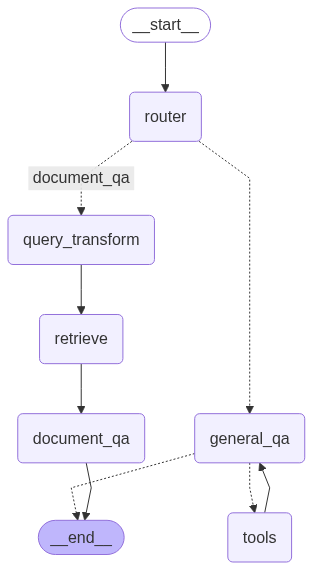

그래프 시각화 완료!
🤖 LangGraph 라우팅 RAG 챗봇 시작 (멀티턴 대화 지원)
💡 '종료' 입력 시 대화를 끝냅니다.
💡 '히스토리' 입력 시 현재 대화 히스토리를 확인합니다.
🤖 AI: 🚀 쿼리 분류 중 (Sonnet 4)...
분류 결과: general (이유: 사용자가 "애국가 1절 알려줘"라고 요청했는데, 이는 특정 문서의 내용을 묻는 것이 아니라 일반적인 지식(애국가 가사)에 대한 질문입니다. 애국가는 대한민국의 국가로서 일반 상식에 해당하며, 특정 문서를 참조해야 하는 질문이 아닙니다.) - Sonnet 4
🚀 일반 응답 생성 중 (Sonnet 4 + 웹 툴)...
✅ 일반 응답 생성 완료 (Sonnet 4)
[{'text': '**사고:** 사용자가 대한민국 애국가 1절을 요청했습니다. 이는 일반적인 상식으로 답변 가능한 질문으로, 웹 검색이 필요하지 않습니다.\n\n**행동:** 직접 답변\n\n**답변:** \n\n안녕하세요! 대한민국 애국가 1절을 알려드리겠습니다.\n\n🇰🇷 **애국가 1절**\n\n동해물과 백두산이 마르고 닳도록\n하느님이 보우하사 우리나라 만세\n무궁화 삼천리 화려강산\n대한사람 대한으로 길이 보전하세\n\n**후렴:**\n무궁화 삼천리 화려강산\n대한사람 대한으로 길이 보전하세\n\n애국가는 우리나라를 사랑하는 마음을 담은 소중한 국가입니다. 다른 절도 궁금하시면 언제든 말씀해 주세요!', 'type': 'text', 'index': 0}]
🤖 AI: 🚀 쿼리 분류 중 (Sonnet 4)...
분류 결과: document (이유: "3절은?"이라는 질문은 특정 문서의 3절(3번째 섹션/장)에 대해 묻는 질문으로, 문서의 구체적인 내용이나 구조에 관한 질문입니다. 이는 문서 내용에 관한 질문에 해당합니다.) - Sonnet 4
🔄 쿼리 변환 중 (Sonnet 4)...
✅ 쿼리 변환 완료: '3절은?' → '**쿼리 변환 결과:**

**원본 쿼리:** "3절은?"

**변환된 쿼리:** "애국가 3절 가사 세

In [16]:
main()